In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
ROOT_DIR = 'LFW_dataset/'

In [3]:
img_path = []
cls = []
for clss in os.listdir(ROOT_DIR):
        for img_file in os.listdir(ROOT_DIR+clss):
            img_path.append(ROOT_DIR+''+clss+'/'+img_file)
            cls.append(clss)

In [4]:
enc = LabelEncoder()
y = np.array(cls)
y = enc.fit_transform(y)

In [5]:
apn = []
for index in np.random.permutation(len(img_path)):
    anchor = img_path[index]
    y_anchor = y[index]     
    pos_index = np.where(y == y_anchor)[0]
    neg_index = np.where(y != y_anchor)[0]
    positive_file = img_path[pos_index[np.random.randint(0, len(pos_index) - 1)]]
    negative_file = img_path[neg_index[np.random.randint(0, len(neg_index) - 1)]]    
    apn.append([anchor, positive_file, negative_file])

In [6]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(gray, frame):
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
    return face

def load_img(file_path):
    img = cv2.imread(file_path)
    color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = detect_face(gray_img, color_img)
    face = cv2.resize(face, (160,160))
    face = face / 255.0
    return face

In [7]:
def create_data(apn, y, batch_size):
    anchor_batch = np.empty((batch_size, 160,160,3))
    positive_batch = np.empty((batch_size, 160,160,3))
    negative_batch = np.empty((batch_size, 160,160,3))

    for i in range(0, batch_size):
        index = random.randint(0, len(apn)-1)
        anchor_file, positive_file, negative_file = apn[index]
        anchor = load_img(anchor_file)
        positive = load_img(positive_file)
        negative = load_img(negative_file)
        anchor_batch[i] = anchor
        positive_batch[i] = positive
        negative_batch[i] = negative

    return [anchor_batch, positive_batch, negative_batch]

In [8]:
def batch_generator(img_path, y ,batch_size):
    while True:
        x = create_data(img_path, y ,batch_size)
        emb_size = 128
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [9]:
embedding_model = tf.keras.models.load_model('./facenet.h5')
embedding_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [10]:
input_anchor = tf.keras.layers.Input(shape=(160,160,3))
input_positive = tf.keras.layers.Input(shape=(160,160,3))
input_negative = tf.keras.layers.Input(shape=(160,160,3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative],output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_1[0][0]                    
                                                                 input_2[0][0]                

In [11]:
alpha = 0.2
emb_size = 128

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)



net.compile(loss=triplet_loss, optimizer='adam')

In [12]:
net.fit(batch_generator(apn, y ,8),epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 16s 796ms/step - loss: 0.0173
Epoch 2/2
20/20 [==============================] - 16s 799ms/step - loss: 0.0359


In [13]:
def valuate(a, b):
    db_face = load_img(img_path[a])
    verify_face = load_img(img_path[b])
    db_face = np.expand_dims(db_face, 0)
    db_emb = embedding_model.predict(db_face)
    verify_face = np.expand_dims(verify_face, 0)
    verify_emb = embedding_model.predict(verify_face)
    result = euclidean_distances(db_emb, verify_emb)[0][0]
    return result

In [14]:
def triplet(face):
    plt.figure(figsize=(12,12))
    names = ['Anchor', 'Positive', 'Negative']
    for i, faces in enumerate(face):
        plt.subplot(1,3,i+1)
        plt.imshow(faces)
        plt.title(names[i])
    plt.show()

In [15]:
def results(a, p, n):
    anchor_face = load_img(img_path[a])
    positive_face = load_img(img_path[p])
    negative_face = load_img(img_path[n])

    result1 = valuate(a, p)
    result2 = valuate(a, n)

    triplet([anchor_face, positive_face, negative_face])
    print('Anchor to Positive :', result1)
    print('Anchor to Negative :', result2)

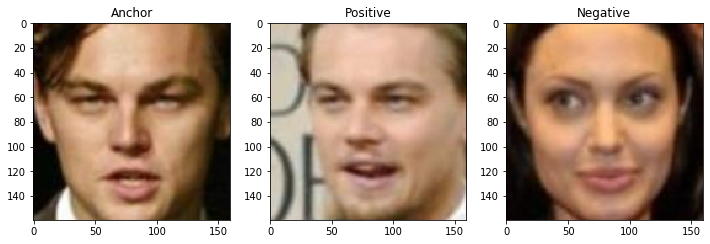

Anchor to Positive : 9.154396
Anchor to Negative : 6.679447


In [18]:
results(21,23,33)